In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from mlxtend.plotting import plot_confusion_matrix


In [2]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

In [3]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

In [4]:
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Hub version: {hub.__version__}")

TensorFlow version: 2.15.0
TensorFlow Hub version: 0.16.1


In [ ]:

# Define the model with Sequential API
model = tf.keras.Sequential([
    hub_layer,  # Directly use hub_layer without redefining Input
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Verify the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                     

In [7]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [9]:
history = model.fit(train_data.shuffle(10000).batch(512), epochs = 5, validation_data = validation_data.batch(512), verbose=1)

Epoch 1/5



30/30 [==============================] - 24s 736ms/step - loss: 0.6627 - accuracy: 0.6743 - val_loss: 0.6121 - val_accuracy: 0.7913
Epoch 2/5
30/30 [==============================] - 22s 737ms/step - loss: 0.3933 - accuracy: 0.8252 - val_loss: 0.5151 - val_accuracy: 0.8546
Epoch 3/5
30/30 [==============================] - 22s 727ms/step - loss: 0.2671 - accuracy: 0.8934 - val_loss: 0.4228 - val_accuracy: 0.8718
Epoch 4/5
30/30 [==============================] - 22s 729ms/step - loss: 0.1819 - accuracy: 0.9321 - val_loss: 0.3577 - val_accuracy: 0.8836
Epoch 5/5
30/30 [==============================] - 22s 746ms/step - loss: 0.1109 - accuracy: 0.9632 - val_loss: 0.3075 - val_accuracy: 0.8839


In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.3238 - accuracy: 0.8724 - 2s/epoch - 50ms/step
loss: 0.324
accuracy: 0.872


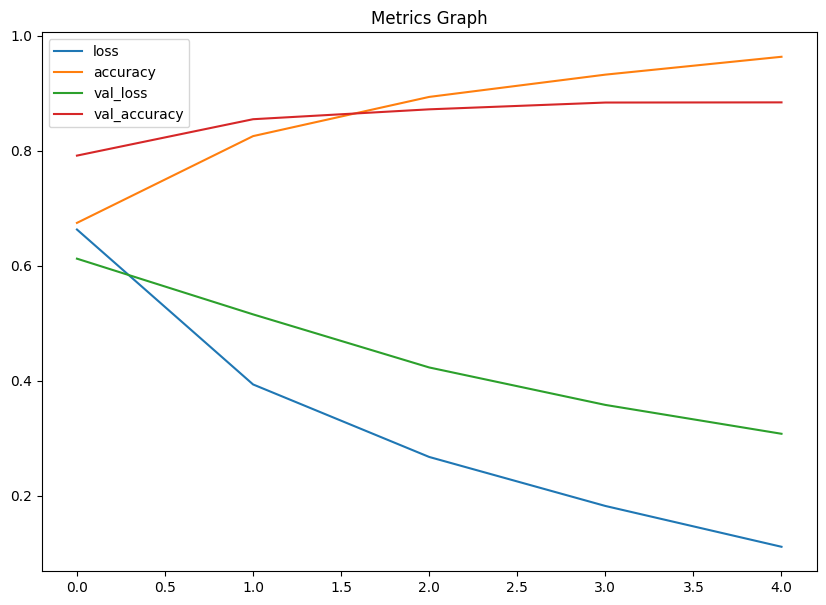

In [11]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.title("Metrics Graph")
plt.show()

In [14]:
texts = []
true_labels = []
for text, label in test_data:
    texts.append(text.numpy())
    true_labels.append(label.numpy())
texts = np.array(texts)
true_labels = np.array(true_labels)

In [15]:
predicted_probs = model.predict(texts)

782/782 [==============================] - 32s 41ms/step


In [16]:
predicted_labels = (predicted_probs > 0.5).astype(int)

In [17]:
true_labels

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [18]:
report = classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87     12500
    Positive       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



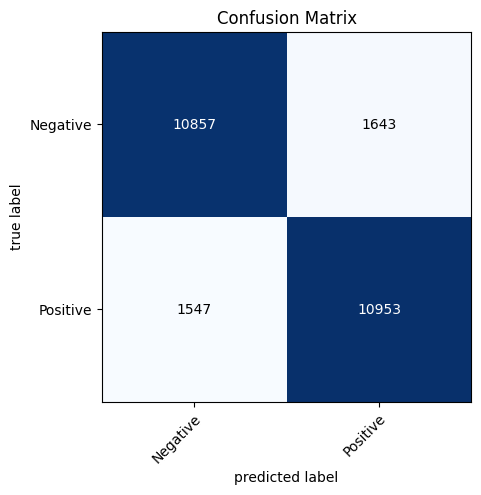

In [20]:
cm = confusion_matrix(true_labels, predicted_labels)
plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.show()